[View in Colaboratory](https://colab.research.google.com/github/hkaur2001/Week3_public/blob/master/HK_TFIDF_model.ipynb)

### **Imports**

In [0]:
import sys
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

In [2]:
! pip install PyDrive

### **Loading the data**

In [0]:
### authentication -- run once 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
### lists the files in the folder 
file_list = drive.ListFile({'q': "'18sX8Dymv_AAEaY7mJxbmh_LjljD8oRwK' in parents and trashed=false"}).GetList() ## long string in the url of folder
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: data_tweet_clean_500_1.csv, id: 1GYKiwwT9vk2msc53mSAUchmb37nTDdJP
title: data_tweet_clean_500_1, id: 1NpwnlyjqIPfaP17zsFjlrApdR18KdUbQNnFaDfambGs
title: data_tweet_clean_500_1, id: 1uMqBX5G--17uD-lUfvjz87202vNvyhQM3chdrAP0Lgw
title: Data Cleaning, id: 1JsVnP9kago0ipdSqtX7txLQWMTwSPZ3X
title: data_Tweet_clean.csv, id: 1FNa4-dHR6aEeunRIwMnaBBacSlCHZOsW
title: Medication_1, id: 1yvcgD5F6on7s9gwS56GWajZNPtvYg_4H
title: Twitter_Neg_Pos, id: 1-SvbE_55FqDfqtp588p3HvcojmREUOWc


In [6]:
### download the file 
file_downloaded = drive.CreateFile({'id': '1VjuYqkkFSILqW2SXvpJo5Ofgyd9ks9OY'})
file_downloaded.GetContentFile('data_tweet_clean_500_1.csv')

df_data = pd.read_csv('data_tweet_clean_500_1.csv', dtype = object)
df_data.head(15)

,Unnamed: 0,Tweet ID,User ID,Bullying_Traces?,Type,Form,Teasing?,Author_Role,Emotion,0
0,0,107688644067856384,185389094,y,self-disclosure,other,n,defender,empathy,b'@bellathorne143 i herd that you got bullied ...
1,1,102206417217392640,226320672,n,NaN,NaN,NaN,NaN,NaN,"b'Bullying: O gesto mais idiota, estpido e irr..."
2,2,102779484725448704,297557032,n,NaN,NaN,NaN,NaN,NaN,b'The Bully at School Goes High Tech Part 1: ...
3,3,108676972149874688,157724561,n,NaN,NaN,NaN,NaN,NaN,b'Esse @Felipemath fazendo bullying comigo! H...
4,4,106590106873372672,62179998,n,NaN,NaN,NaN,NaN,NaN,b'AUISHUAHS eu e o @wallace_mancha tiramos o d...
5,5,109034091743154176,177913822,n,NaN,NaN,NaN,NaN,NaN,"b'@Looweihao @haoyangg @sleepybed Hello, since..."
6,6,102533497637437441,70412906,y,report,other,n,reporter,none,b'For those keeping score at home- cousin who ...
7,8,103679008855691264,11363462,n,NaN,NaN,NaN,NaN,NaN,"b""BETTER ANTI-BULLYING AD SLOGANS: Hey, Bullie..."
8,9,105202476927549441,293593896,n,NaN,NaN,NaN,NaN,NaN,b'@luttylutz bahh lo kaga demen dia juga? Gue ...
9,10,107278521805713408,150964152,n,NaN,NaN,NaN,NaN,NaN,b'cara3: bully iam gara2 uda di ucpin tpi gk bls'


### **Formatting the Data**

In [7]:
def format_class_labels(df):
    
    import re 
    
    # regex the weird class labels out
    regex_pattern = ( "\.\|\d+")

    for index, row in df.iterrows():

        # substitute instances of our regex_pattern for an empty string
        new_class = re.sub(regex_pattern, '', row['Bullying_Traces?'])
        df.loc[index,'Bullying_Traces?']=new_class
    
    # set all negative class labels to 0, all others to 1

    df['Bullying_Traces?'] = df['Bullying_Traces?'].replace('n', 0)                    
    df['Bullying_Traces?'] = df['Bullying_Traces?'].replace('y', 1)     
    
    return df

##fomatted the Bullying_Traces? column to 1 for 'y' and 0 for 'n'
data_train = format_class_labels(df_data)
data_train.head()

,Unnamed: 0,Tweet ID,User ID,Bullying_Traces?,Type,Form,Teasing?,Author_Role,Emotion,0
0,0,107688644067856384,185389094,1,self-disclosure,other,n,defender,empathy,b'@bellathorne143 i herd that you got bullied ...
1,1,102206417217392640,226320672,0,NaN,NaN,NaN,NaN,NaN,"b'Bullying: O gesto mais idiota, estpido e irr..."
2,2,102779484725448704,297557032,0,NaN,NaN,NaN,NaN,NaN,b'The Bully at School Goes High Tech Part 1: ...
3,3,108676972149874688,157724561,0,NaN,NaN,NaN,NaN,NaN,b'Esse @Felipemath fazendo bullying comigo! H...
4,4,106590106873372672,62179998,0,NaN,NaN,NaN,NaN,NaN,b'AUISHUAHS eu e o @wallace_mancha tiramos o d...


In [0]:
data_train.Type.

In [0]:
##train and test split
X_train, X_test, y_train, y_test = train_test_split(data_train['0'], data_train['Bullying_Traces?'], test_size = 0.2)
#X_train

In [0]:
y_train

### **Model: TF-IDF**

In [12]:
from sklearn.metrics import accuracy_score

pipeline = Pipeline([('vect', CountVectorizer(min_df=0.05, max_df=0.75)),('clf', MultinomialNB()),])
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict_proba(X_test)

##predicts outcome with thte highest probability
y_val_predict = [np.argmax(y) for y in y_predicted]

##print accuracy
print(accuracy_score(y_test, y_val_predict))

0.7294117647058823


In [13]:
##confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_val_predict)
cm

array([[55,  8],
       [15,  7]])

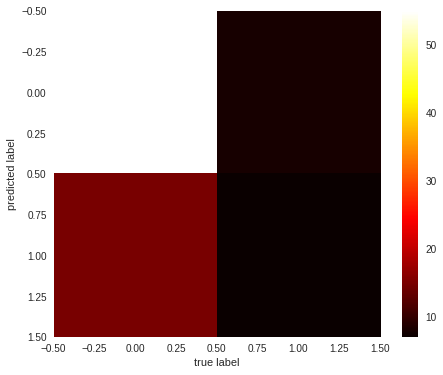

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [17]:
##ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_test, y_predicted[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7734487734487735

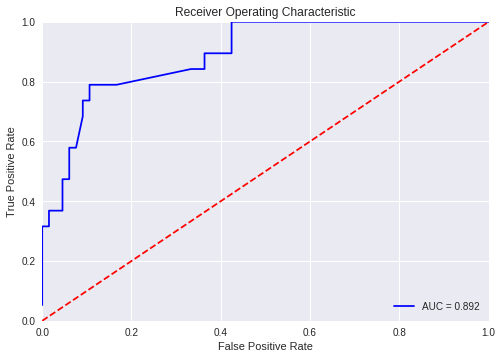

In [53]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()